<a href="https://colab.research.google.com/github/GerardoMunoz/robots/blob/main/Car_dif_kinematics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

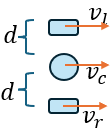

Cuando el robot diferencial tiene la misma velocidad en ambas ruedas avanza hacia adelante a la misma velocidad de las ruedas.

Sin embargo, si la velocidad de las ruedas es diferente describe un círculo, en  el dibujo se asume que $v_l$ < $v_r$ y que describe un  círculo de radio R.

El ángulo $\alpha$ que gira el robot sobre su centro corresponde al arco que describe el robot, como se puede observar en la figura. Es importante destacar que $\dot{\alpha}$ representa la velocidad angular con la que el robot gira sobre su propio centro. Además, $\dot{\alpha}$ también se interpreta como la velocidad angular del robot alrededor del centro del círculo que describe su trayectoria.


Asumiendo que cada rueda está a un distancia d del centro entonces se obtienen las siguientes ecuaciones:
* $v_l=\dot{\alpha}(R-d)$  
* $v_c=\dot{\alpha}R$  
* $v_r=\dot{\alpha}(R+d)$  
Al despejar $R$ de la segunda ecuación y reemplazar en las otras dos se obtienen las siguientes ecuaciones conocidas como **cinemática inversa**:
* $v_l=v_c-\dot{\alpha}d$
* $v_r=v_c+\dot{\alpha}d$
Despejando  $v_c$ al sumar las ecuaciones, y
$\dot{\alpha}$ y al restarlas, obtenemos las ecuaciones conocidas como **cinemática directa**:
* $v_c=(v_r+v_l)/2$
* $\dot{\alpha}=(v_r-v_l)/(2d)$


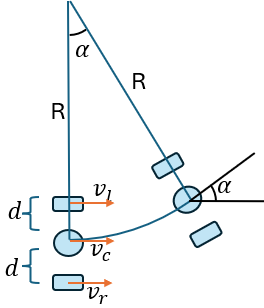

A continuación se encuentra el siguiente código:

* **class Matrix**: es una clase para realizar operaciones vectoriales y matriciales.
* **def bezier_wheels**: es una función que calcula la velocidad angular de las ruedas para que el robot siga una curva de Bézier.
* **def get_robot_coordinates**: es una función que calcula la posición del robot a partir de las velocidades angulares de las ruedas.

Al final, se grafica la curva de Bézier y la trayectoria que sigue el robot.

In [ ]:
import array
import random
from math import cos,sin,sqrt

class Matrix:
    def __init__(self, m, n, data=None):
        self.m = m  # number of rows
        self.n = n  # number of columns
        if data is None:
            self.data = array.array('f', [0.0] * (n * m))
        else:
            if len(data) != n * m:
                raise ValueError("Incorrect data length")
            self.data = array.array('f', data)

    def copy(self):
        return Matrix(self.m,self.n,self.data[:])

    def __getitem__(self, index):
        if isinstance(index,tuple):

           i, j = index
           if isinstance(i,int) and isinstance(j,int):
                if 0 <= i < self.m and 0 <= j < self.n:
                    return self.data[i * self.n + j]
                else:
                    raise IndexError("Matrix indices out of range",i,j)
           if isinstance(i,int) and isinstance(j,slice):
             raise IndexError("One slice is not allow yet ")
           if isinstance(i,slice) and isinstance(j,int):
             raise IndexError("One slice is not allow yet ")
           if isinstance(i,slice) and isinstance(j,slice):
                 start_i, stop_i, step_i = i.indices(self.m)
                 start_j, stop_j, step_j = j.indices(self.n)
                 if step_i!=1 or step_j!=1:
                     raise IndexError("Step must be one")
                 sliced_data = [self.data[r * self.n + c] for r in range(start_i, stop_i, step_i) for c in range(start_j, stop_j, step_j)]
                 return Matrix(stop_i - start_i, stop_j - start_j, sliced_data)
           else:
                 raise IndexError("i,j indices are required")
        else:
            raise ValueError("i,j indices are required")

    def __setitem__(self, index, value):
        i, j = index
        if 0 <= i < self.m and 0 <= j < self.n:
            self.data[i * self.n + j] = value
        else:
            raise IndexError("Matrix indices out of range",i,j)

    def __add__(self, other):
        #print('add',self.m,self.n,other.m,other.n)
        if isinstance(other, Matrix) and self.n == other.n and self.m == other.m:
            result = Matrix(self.m, self.n)
            for i in range(self.m):
                for j in range(self.n):
                    result[i, j] = self[i, j] + other[i, j]
            return result
        else:
            raise ValueError("Matrices of different dimensions cannot be added",self.m,self.m,other.m,other.n)

    def __sub__(self, other):
        #print('sub',self.m,self.n,other.m,other.n)
        if isinstance(other, Matrix) and self.n == other.n and self.m == other.m:
            result = Matrix(self.m, self.n)
            for i in range(self.m):
                for j in range(self.n):
                    result[i, j] = self[i, j] - other[i, j]
            return result
        else:
            raise ValueError("Matrices of different dimensions cannot be subtracted",self.m,self.m,other.m,other.n)

    def __mul__(self, other):
        if isinstance(other, (int, float)):
            result = Matrix(self.m, self.n)
            for i in range(self.m):
                for j in range(self.n):
                    result[i, j] = self[i, j] * other
            return result
        elif isinstance(other, Matrix):
            #print('mul',self.m,self.n,other.m,other.n)
            if self.n != other.m:
                raise ValueError("Number of columns of first matrix must be equal to number of rows of second matrix")
            result = Matrix(self.m, other.n)
            for i in range(self.m):
                for j in range(other.n):
                    for k in range(self.n):
                        result[i, j] += self[i, k] * other[k, j]
            return result
        else:
            raise ValueError("Multiplication not defined for these data types")

    def __rmul__(self, other):
      return self * other


    def T(self):
        transposed_data = array.array('f', [0.0] * (self.n * self.m))
        for i in range(self.m):
            for j in range(self.n):
                transposed_data[j * self.m + i] = self.data[i * self.n + j]
        return Matrix(self.n, self.m, transposed_data)

    def __or__(self,other):
        """
        concatenate vertically
        """
        if isinstance(other, Matrix) and self.n == other.n :
            return Matrix(self.m + other.m, self.n,self.data+other.data)
        else:
            raise ValueError("Matrices of different dimensions cannot be added")

    def __and__(self, other):
        """
        Concatenate two matrices horizontally.

        Args:
            other (Matrix): The second matrix to concatenate.

        Returns:
            Matrix: The resulting matrix after horizontal concatenation.
        """
        if self.m != other.m:
            raise ValueError("Matrices must have the same number of rows to concatenate horizontally")

        concatenated_data = []
        for i in range(self.m):
            concatenated_data.extend(self.data[i*self.n : (i+1)*self.n])
            concatenated_data.extend(other.data[i*other.n : (i+1)*other.n])

        return Matrix(self.m, self.n + other.n, concatenated_data)

    def norm2(self):
        return sum(a**2 for a in  self.data)

    def norm(self):
        return sqrt(sum(a**2 for a in  self.data))

    def det2x2(self):
        return self[0,0]*self[1,1]-self[1,0]*self[0,1]


    def repeat_vertically(self,n):
         return Matrix(self.m *n, self.n,self.data *n)

    def rot2D(a):#static
        return Matrix(3,3,[cos(a),sin(a), 0,
                           -sin(a), cos(a), 0,
                           0     , 0     , 1])

    def tras2D(x,y):#static
        return Matrix(3,3,[1, 0, 0,
                           0, 1, 0,
                           x, y, 1])

    def untail(self,m):
       return Matrix(m.m,m.n-1,[m.data[i] for i in range(len(m.data))  if i%m.n != m.n-1])

    def __str__(self):
        output = ""
        for i in range(self.m):
            row_str = " ".join(str(self[i, j]) for j in range(self.n))
            output += row_str + "\n"
        return output

In [ ]:
from math import atan2

def bezier_wheels(P0,P1,P2,P3,duration=5,steps=100,radio_w=0.5,dist_w=1):
    r=radio_w
    b=dist_w/2
    delta_tao=duration/steps
    B_ant=P0 # si asume 0 baja nota

    dif=P1-P0
    gamma_ant=atan2(dif[0,1],dif[0,0]) # si asume 0 baja nota

    omegas_wheels = []

    for i in range (1,101):
        t=i/100
        B_act=(1-t)**3 * P0 + 3*(1-t)**2 * t * P1 + 3*(1-t) * t**2 * P2 + t**3 * P3
        dif=B_act-B_ant
        v_robot=dif.norm()/delta_tao
        gamma_act=atan2(dif[0,1],dif[0,0])
        omega_robot = (gamma_act-gamma_ant)/delta_tao #omega = angular vel
        omega_wheel_left = (v_robot - b * omega_robot)/r
        omega_wheel_right = (v_robot + b * omega_robot)/r
        omegas_wheels.append((omega_wheel_left,omega_wheel_right))
        B_ant=B_act
        gamma_ant=gamma_act
    return omegas_wheels



P0 = Matrix(1,3,[1,0,1])
P1 = Matrix(1,3,[1,-2,1])
P2 = Matrix(1,3,[6,3,1])
P3 = Matrix(1,3,[3,3,1])
omegas_wheels = bezier_wheels(P0,P1,P2,P3)
print(omegas_wheels)



NameError: name 'Matrix' is not defined

In [ ]:


def get_robot_coordinates(omegas_wheels, duration=5,steps=100,radio_w=0.5,dist_w=1):
    r=radio_w
    b=dist_w/2
    delta_tao=duration/steps

    x = P0[0,0]
    y = P0[0,1]
    dif=P1-P0
    angle=atan2(dif[0,1],dif[0,0])
    posi=P0
    robot_coordinates = []

    for i in range(len(omegas_wheels)):
        x = (omegas_wheels[i][0] * r + omegas_wheels[i][1] * r) / 2* delta_tao
        omega_robot = (omegas_wheels[i][1] * r - omegas_wheels[i][0] * r) / (2 * b)* delta_tao
        desp = Matrix(1,3,[x,y,1])*Matrix.rot2D(angle)
        posi= posi +desp
        angle+=omega_robot
        robot_coordinates.append([posi[0, 0], posi[0, 1]])
    return robot_coordinates

robot_coordinates = get_robot_coordinates(omegas_wheels)



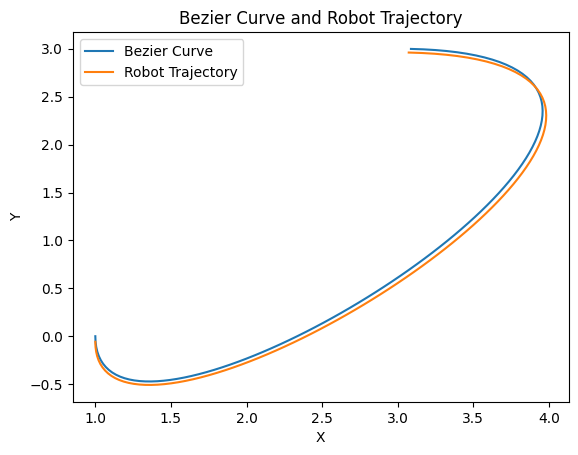

In [ ]:
import matplotlib.pyplot as plt

def B(t):
  return (1-t)**3 * P0 + 3*(1-t)**2 * t * P1 + 3*(1-t) * t**2 * P2 + t**3 * P3

bezier=[B(i/100) for i in range(100) ]
bezier_x = [bz[0,0] for bz in bezier]
bezier_y = [bz[0,1] for bz in bezier]

robot_x = [coordinate[0] for coordinate in robot_coordinates]
robot_y = [coordinate[1] for coordinate in robot_coordinates]

plt.plot(bezier_x, bezier_y, label="Bezier Curve")

plt.plot(robot_x, robot_y, label="Robot Trajectory")

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Bezier Curve and Robot Trajectory")

plt.legend()
plt.show()
# Modelo de la Bicicleta

El modelo de la bicicleta es una simplificación del movimiento de vehículos con dirección delantera, como un carro o un robot tipo coche RC.

## Ecuaciones del modelo

El movimiento del vehículo se describe mediante las siguientes ecuaciones diferenciales:

\[
\begin{aligned}
\dot{x} &= v \cdot \cos(\theta) \\
\dot{y} &= v \cdot \sin(\theta) \\
\dot{\theta} &= \frac{v}{L} \cdot \tan(\delta)
\end{aligned}
\]

## Definiciones

- $ x, y $: posición del vehículo en el plano
- $ \theta $: orientación del vehículo respecto al eje X (en radianes)
- $ v $: velocidad lineal del vehículo (en la dirección de la rueda trasera)
- $ \delta $: ángulo del timón (rueda delantera respecto al cuerpo del vehículo)
- $ L $: distancia entre ejes (entre la rueda delantera y trasera)

## Consideraciones

- La rueda trasera no gira lateralmente, solo avanza en línea recta.
- La rueda delantera gira con ángulo $ \delta $ y dirige la trayectoria del vehículo.
- Se asume que no hay deslizamiento lateral.

Este modelo es ampliamente usado en simulación y control de robots móviles y vehículos con dirección delantera.



# Modelo de la Bicicleta

El modelo de la bicicleta es una simplificación del movimiento de vehículos con dirección delantera, como un carro o un robot tipo coche RC.

* $r_d=\frac{L}{\sin(\alpha)}$
* $r_t=\frac{L}{\tan(\alpha)}$

Si avanza un ángulo $\beta$:
* El arco de la rueda trasera es $\beta r_t$
* El arco de la rueda delantera es $\beta r_d$

El modelo utiliza la rueda trasera, se asume que siempre apunta hacia la rueda delantera.


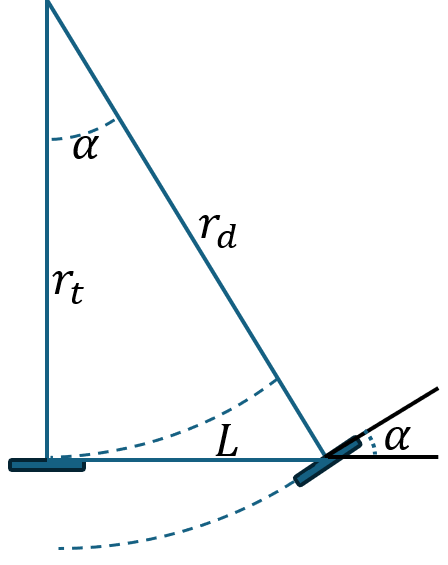


## Ecuaciones del modelo

El movimiento del vehículo se describe mediante las siguientes ecuaciones diferenciales:

$$
\begin{aligned}
\dot{x} &= v \cdot \cos(\beta) \\
\dot{y} &= v \cdot \sin(\beta) \\
\dot{\beta} &= \frac{v}{L} \cdot \tan(\alpha)
\end{aligned}
$$

## Definiciones

- $ x, y $: posición del vehículo en el plano
- $ \beta $: orientación del vehículo (vector que une las ruedas) respecto al eje X (en radianes)
- $ v $: velocidad lineal del vehículo (en la dirección de la rueda trasera)
- $ \alpha $: ángulo del timón (rueda delantera respecto al cuerpo del vehículo)
- $ L $: distancia entre ejes (entre la rueda delantera y trasera)

## Consideraciones

- La rueda trasera no gira lateralmente, solo avanza en línea recta.
- La rueda delantera gira con ángulo $ \alpha $ y dirige la trayectoria del vehículo.
- Se asume que no hay deslizamiento lateral.

Este modelo es ampliamente usado en simulación y control de robots móviles y vehículos con dirección delantera.



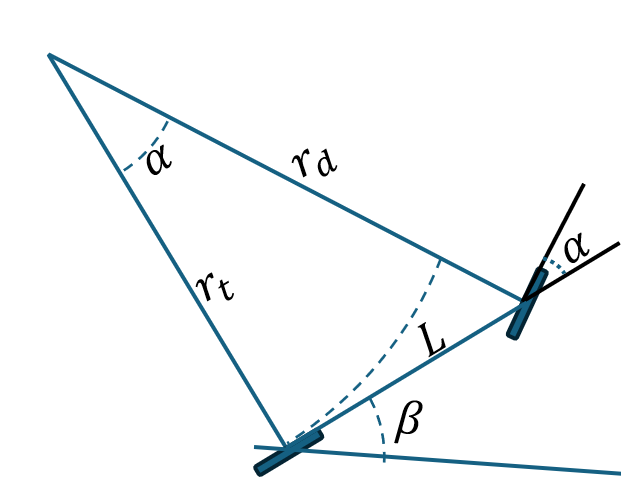